# Keras and Tensorflow implementation of SGAN on MNIST data set

## Goals:
1. Semi-supervised training using Wasserstein GANs
2. Network visualization with tensorboard
3. Training visualisation with tensorboard
4. 3D embedding visualisation
5. Port final solution to Traffic sign classification task with 3 channels

In [2]:
#Import all libraries and MNIST dataset
import keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.datasets import mnist
import pandas as pd

img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


![Basic GAN architecture](generative-adversarial-network.png)

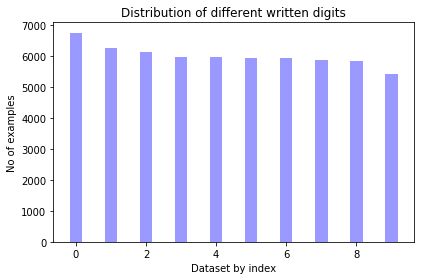

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#Data cleaning and dataset visualization

#Make data consumable with Keras
#Train data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], -1).astype('float32')
Y_train = y_train.reshape(y_train.shape[0], -1).astype('float32')
#Test data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], -1).astype('float32')
Y_test = y_test.reshape(y_test.shape[0], -1).astype('float32')

#Normalize all data [0, 1] with mean zero
X_train/=255
X_test/=255

#Plot distribution of data set
def barchart(y_data, title, x_axis_label, y_axis_label):
    d_count = pd.Series(y_data).value_counts().tolist()
    n_groups = len(d_count)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    plt.bar(index, d_count, bar_width,
                     alpha=opacity,
                     color='b')
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

barchart(y_train, 'Distribution of different written digits', 'Dataset by index', 'No of examples')

In [46]:
#Build the generative and adversarial models
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.layers import Merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers import ZeroPadding2D, Deconvolution2D
from keras.callbacks import TensorBoard

def Generator(LatentVector):
    #Size of latent matrix
    latent_vector_size = LatentVector
    
    width =  14  # Hand picked width of the 'meta' image 
    filters = 20 # No of the kernels in convolution
    
    latent_vector_input = Input(shape=[latent_vector_size])
    G = Dense(width*width*filters, kernel_initializer='glorot_normal')(latent_vector_input)
    
    G = BatchNormalization(axis=1)(G)
    G = LeakyReLU(0.2)(G)

    G = Reshape([width, width, filters])(G)
    G = UpSampling2D(size=(2, 2))(G)
    G = Conv2D(filters = filters//2, kernel_size=(3, 3), padding='same', kernel_initializer='glorot_uniform')(G)

    G = BatchNormalization(axis=1)(G)
    G = LeakyReLU(.2)(G)
    
    G = Conv2D(filters=width//4, kernel_size=(3, 3), padding='same')(G)
    G = BatchNormalization(axis=1)(G)
    G = LeakyReLU(.2)(G)
    G = Conv2D(filters = 1, kernel_size=(1, 1), padding='same')(G)
    generated_image = Activation('sigmoid')(G)
    
    #Final model
    model = Model(inputs=latent_vector_input, outputs=generated_image)
    model.compile(loss='binary_crossentropy', optimizer="SGD")
    return model

def Discriminator(ImageShape):
    InputImage = Input(ImageShape)
    D = Conv2D(filters=16, kernel_size=(5, 5), padding= 'same')(InputImage)
    D = LeakyReLU(.2)(D)
    D = MaxPooling2D(pool_size=(2, 2))(D)
    D = Conv2D(filters=32,  kernel_size=(5, 5), padding = 'same')(D)
    D = MaxPooling2D(pool_size=(2, 2))(D)
    D = Flatten()(D)
    D = Dense(256)(D)
    D = LeakyReLU(.2)(D)
    D = Dense(1)(D)
    D = Activation('sigmoid')(D)
    
    #Final model
    model = Model(inputs=InputImage, outputs=D)
    
    return model

def GeneratorWithDiscriminator(Generator, Discriminator):
    #Freeze weights in Descriminator as part of minimax game
    Discriminator.trainable = False
    
    #Create Generator Trainer
    model = Sequential()
    model.add(Generator)
    model.add(Discriminator)
    
    return model  

#Test models   
Generator(LatentVector=100).summary()
Discriminator((28, 28, 1)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 3920)              395920    
_________________________________________________________________
batch_normalization_40 (Batc (None, 3920)              15680     
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 3920)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 14, 14, 20)        0         
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 28, 28, 20)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 10)        1810      
__________

In [207]:
#Generate image sprites to show training
import math
def SpriteGen(image_batches):
    #Convert to 8 bit matrix between 0 & 255
    image_batches = (image_batches*127.5+127.5).astype(np.uint8)
    
    number_of_images = image_batches.shape[0]
    
    #Height and width of final sprite image:
    height = int(math.sqrt(number_of_images))
    width = int(math.ceil(number_of_images/height))
    
    image_dim = image_batches.shape[1:]
    
    #Final output sprite image:s
    sprite = np.zeros((height*image_dim[0], width*image_dim[1]))

    for index, img in enumerate(image_batches):
        i = int(index/width)
        j = index % width
        sprite[i*image_dim[0]:(i+1)* image_dim[0], j*image_dim[1]:(j+1)*image_dim[1]] = \
            image_batches[0, :, :].reshape(image_dim[0], image_dim[1])
   
    return sprite       

In [226]:
#Training models and training function
from sklearn.utils import shuffle

#Create callback for graph visualizations with tensorboard
#GAN_callback = keras.callbacks.TensorBoard(log_dir='../Graph/GAN_graph', histogram_freq=1,  
#          write_graph=True, write_images=True)

def Train(BatchSize, Epochs, LatentVectorSize, DataSet):
    #Set up discriminator
    discriminator = Discriminator(ImageShape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy', optimizer="SGD")
    discriminator.trainable = True
    
    #Set up generator
    generator = Generator(LatentVector=LatentVectorSize)
    #generator = Generator.compile(loss='binary_crossentropy', optimizer="SGD")
    
    #Set up GAN
    GAN = GeneratorWithDiscriminator(Generator=generator, Discriminator=discriminator)
    GAN.compile(loss='binary_crossentropy', optimizer="SGD")

    #Get Data
    X_train, Y_train, X_test, Y_test = DataSet
    
    for Epoch in range(Epochs):
    #Training sequence: -> Generator -> Descriminator -> GAN
        print('Epoch: {}'.format(Epoch))
        
        #Get training data and shuffle
        X_train, Y_train = shuffle(X_train, Y_train)
        
        for offset in range(0,200, BatchSize):
            end = offset + BatchSize
            batch_X_train, batch_Y_train = X_train[offset:end], Y_train[offset:end]
            noise_batch = np.random.uniform(-1, 1, (BatchSize, LatentVectorSize))
               
            #Generate images from Generator
            GeneratedImages =  np.asarray(generator.predict(noise_batch, verbose=1))
            
            #Save every image every 50 batches and 10 epochs
            if offset%50==0 and Epoch%10==0:
                SpriteImg = SpriteGen(GeneratedImages)
                Image.fromarray(SpriteImg, mode='RGB').save("TrainingImages/Epoch_"+str(Epoch)+"_"+\
                                               "Batch_"+str(offset)+".png")
            #Generate GAN training data
            combined_X_train =  np.vstack((batch_X_train, GeneratedImages))
            combined_Y_train = [1]*BatchSize + [0]*BatchSize
            
            #Discriminator
            d_loss = discriminator.train_on_batch(combined_X_train, combined_Y_train)
            
            #Train on GAN
            discriminator.trainable = False
            g_loss = GAN.train_on_batch(noise_batch, np.ones(BatchSize))
            discriminator.trainable = True
            
            #Save weights every 10 batches
            if offset%10 == 0:
                generator.save('Generator.h5')
                discriminator.save('Discriminator.h5')
            
        print("Batch: {}, Discriminator Loss: {}".format(offset, d_loss))
        print("Batch: {}, Generator Loss: {}".format(offset, g_loss))                        

In [227]:
#Set training parameters
Train(BatchSize=200, Epochs=1, LatentVectorSize=100, DataSet=(X_train, Y_train, X_test, Y_test))

Epoch: 0
192/200 [===========================>..] - ETA: 0sBatch: 0, Discriminator Loss: 0.6593846082687378
Batch: 0, Generator Loss: 0.7994616031646729


In [224]:
#Generate images from generator
from keras.models import load_model
def GenImages(latent_vector):
    generator = load_model('Generator.h5')
    return generator.predict(latent_vector)

noise =  np.zeros((16, 100))
for i in range(16):
    noise[i, :] = np.random.uniform(-1, 1, 100)
    
TestOut = GenImages(noise)

(112, 112)


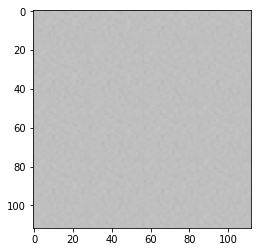

In [225]:
#Generate 16 generator images
from PIL import Image
Test = SpriteGen(TestOut)
print(Test.shape)

Timage = Image.fromarray(Test)
plt.imshow(Timage, cmap ='gray')